In [1]:
import json
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, GRU, LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
import itertools
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sys, os
import traceback
from itertools import chain
import numpy as np
import pandas as pd

import tensorflow as tf


import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [6]:
# def get_sentences(data_list):
#     sentences = []
#     done = 0
#     for a in data_list.article.unique():
#         words = []
#         prev_n = 0
#         for _,s in data_list.loc[data_list.article == a].iterrows():
#             n = s['sentence_no']
#             if n != prev_n:
#                 if len(words) > 2 and len(set([x[1] for x in words])) > 1:
#                     sentences.append(words)
#                 words = []
#             words.append((s['word'], s['encoding'], s['part_of_speech']))
#             prev_n = n
            
#         if len(words) > 2 and len(set([x[1] for x in words])) > 1:
#             sentences.append(words)
#         done += 1
#         sys.stdout.write('Done with {} sentence from 22726.\r'.format(done));
#         sys.stdout.flush()
#     return sentences

def get_sentences(data_list):
    sentences = []
    indices = data_list.index.unique()
    done = 0
    for i in indices:
        
        temp = data_list.ix[i]
        n_encodings = len(temp.encoding.unique())
        words = temp[['word','encoding','part_of_speech']].values
        if len(words) > 2 and n_encodings > 1:
            sentences.append(words)
        done += 1
        sys.stdout.write('Done with {} sentence from 22726.\r'.format(done));
        sys.stdout.flush()
    return sentences

In [17]:
data_list = pd.read_csv('../data/go/go_cc3.csv')
data_list.word.fillna('NA', inplace=True)
data_list.encoding = data_list.encoding.apply(lambda x: x if x != 'B_O' else 'O')

temp = pd.read_csv('../data/go/go_bp3.csv')
temp.word.fillna('NA', inplace=True)
temp.encoding = temp.encoding.apply(lambda x: x if x != 'B_O' else 'O')

temp1 = pd.read_csv('../data/go/go_mf3.csv')
temp1.word.fillna('NA', inplace=True)
temp1 = temp1.rename(columns={'encoding' : 'encoding_z'})
temp1.encoding_z = temp1.encoding_z.apply(lambda x: x if x != 'B_O' else 'O')

data_list = data_list.merge(temp, on=['article', 'sentence_no', 'word_no'])
data_list = data_list.merge(temp1, on=['article', 'sentence_no', 'word_no'])
data_list.sort_values(['article', 'sentence_no'], kind='mergesort', inplace=True)
x_counts = data_list.encoding_x.value_counts()
y_counts = data_list.encoding_y.value_counts()
z_counts = data_list.encoding_z.value_counts()
# data_list['encoding_x'] = data_list.encoding_x.apply(lambda x: x if x_counts[x] > 4 else 'O')
# data_list['encoding_y'] = data_list.encoding_y.apply(lambda x: x if y_counts[x] > 4 else 'O')
# data_list['encoding'] = [i if (i == 'O' and j == 'O') else j for i,j in zip(data_list.encoding_x, data_list.encoding_y)]
temp_encoding = []
for i,j,k in zip(data_list.encoding_x, data_list.encoding_y, data_list.encoding_z):
    if i == j and j == k:
        temp_encoding.append('O')
    elif i == 'O' and j != 'O':
        temp_encoding.append(j)
    elif j == 'O' and i != 'O':
        temp_encoding.append(i)
    else:
        temp_encoding.append(k)
data_list['encoding'] = temp_encoding
data_list.drop(['word_x', 'word_y', 'part_of_speech_x', 'part_of_speech_y',
                'encoding_x', 'encoding_y', 'encoding_z'], axis=1, inplace=True)
data_list.set_index(['article', 'sentence_no'], inplace=True)

# val_cnt = data_list.encoding.value_counts()
# data_list['encoding'] = data_list.encoding.apply(lambda x: 'O' if val_cnt[x] < 5 else x)
# data_list = data_list.rename(columns={'word_x' : 'word'})

In [18]:
data_list = get_sentences(data_list)
print(data_list[0])
print(len(data_list))

words = list(set(y[0] for x in data_list for y in x))
n_words = len(words)
print(n_words)

tags = list(set(y[1] for x in data_list for y in x))
tags.remove('O')
n_tags = len(tags)
print(n_tags)

poss = list(set(y[2] for x in data_list for y in x))
n_poss = len(poss)
print(n_poss)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


[['Gender' 'O' 'NN']ence from 22726.
 ['does' 'O' 'VBZ']
 ['not' 'O' 'RB']
 ['typically' 'O' 'RB']
 ['affect' 'O' 'JJ']
 ['IOP' 'O' 'NNP']
 ['and' 'O' 'CC']
 ['aging' 'B_GO:0007568' 'VBG']
 ['results' 'O' 'NNS']
 ['in' 'O' 'IN']
 ['an' 'O' 'DT']
 ['IOP' 'O' 'NNP']
 ['decrease' 'O' 'NN']
 ['in' 'O' 'IN']
 ['some' 'O' 'DT']
 ['strains' 'O' 'NNS']
 ['.' 'O' '.']]
7894
16446
1369
44


In [19]:
max_len = 75
max_len_char = 15

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["O"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["O"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

pos2idx = {w: i+1 for i, w in enumerate(poss)}
pos2idx["X"] = 0
idx2pos = {i: w for w, i in pos2idx.items()}

In [20]:
print(tag2idx)

{'I_GO:0008380': 1, 'I_GO:0035556': 691, 'B_GO:0005577': 2, 'B_GO:0036367': 692, 'B_GO:0006289': 3, 'B_GO:0071850': 477, 'I_GO:0014032': 1180, 'B_GO:0010424': 4, 'I_GO:0044430': 694, 'B_GO:0051546': 695, 'B_GO:0001171': 5, 'I_GO:0030041': 6, 'I_GO:0005783': 696, 'B_GO:0007132': 7, 'I_GO:0006306': 8, 'B_GO:0014018': 9, 'B_GO:0006273': 10, 'I_GO:0043043': 11, 'I_GO:0048568': 698, 'B_GO:0006266': 699, 'B_GO:0019953': 12, 'B_GO:0043473': 700, 'I_GO:0007596': 13, 'B_GO:0000795': 14, 'I_GO:0002087': 15, 'I_GO:0042622': 702, 'B_GO:0070382': 16, 'B_GO:0048539': 483, 'B_GO:0001774': 703, 'I_GO:0016477': 704, 'B_GO:0014010': 124, 'B_GO:0048839': 705, 'B_GO:0035328': 17, 'B_GO:0031507': 18, 'B_GO:0030301': 707, 'I_GO:0097418': 708, 'I_GO:0016324': 709, 'I_GO:0006885': 710, 'I_GO:0043005': 19, 'I_GO:0050794': 20, 'I_GO:0010629': 21, 'B_GO:0034205': 22, 'I_GO:0001739': 800, 'B_GO:0030154': 711, 'B_GO:0051318': 23, 'B_GO:0031323': 589, 'I_GO:0042613': 24, 'I_GO:0006915': 25, 'I_GO:0048598': 26, 'I_G

In [21]:
print(pos2idx)

{'EX': 1, 'WRB': 2, 'NNS': 4, 'POS': 5, 'MD': 6, 'JJ': 7, ':': 8, 'VBD': 11, 'SYM': 13, 'X': 0, 'RBS': 14, '(': 15, 'VBN': 16, 'RP': 34, 'WP$': 17, 'VBG': 18, 'NNPS': 20, 'PRP': 12, 'CC': 21, 'NN': 10, 'PDT': 22, 'UH': 23, 'TO': 24, 'IN': 25, 'RBR': 26, ')': 27, 'VBZ': 19, 'NNP': 28, '#': 29, 'DT': 30, ',': 9, 'WDT': 31, "''": 35, '``': 3, '.': 32, '$': 33, 'WP': 37, 'PRP$': 36, 'VB': 38, 'CD': 39, 'JJR': 40, 'VBP': 41, 'RB': 42, 'JJS': 43, 'FW': 44}


In [22]:
from keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in data_list]
X_word_plain = [[w[0] for w in s] for s in data_list]
new_X = []
for seq in X_word_plain:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("ENDPAD")
    new_X.append(new_seq)
X_word_plain = new_X

In [23]:
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["O"], padding='post', truncating='post')

In [24]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

128


In [25]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["O"] = 0

In [26]:
X_char = []
for sentence in data_list:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("O"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))


In [27]:
X_pos = [[pos2idx[w[2]] for w in s] for s in data_list]
X_pos = pad_sequences(maxlen=max_len, sequences=X_pos, value=pos2idx["X"], padding='post', truncating='post')

In [28]:
def getFeatures(w):
    return [w.istitle(), w.islower(), w.isupper(), w.isdigit(), w.isalpha()]
# X_features = [[getFeatures(w[0]) for w in s] for s in data_list]

X_features = []
for sentence in data_list:
    sent_seq = []
    for i in range(max_len):
        try:
            word_seq = getFeatures(sentence[i][0])
        except:
#             word_seq.append([-1,-1,-1,-1,-1,0])
            word_seq = [0]*5
        sent_seq.append(word_seq)
    X_features.append(np.array(sent_seq))
X_features = np.array(X_features)

In [29]:
y = [[tag2idx[w[1]] for w in s] for s in data_list]
y = pad_sequences(maxlen=max_len, sequences=y,value=tag2idx["O"], padding='post', truncating='post')

In [30]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags+1) for i in y]

In [31]:
from sklearn.model_selection import train_test_split
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.3, random_state=2018)
X_word_plain_tr, X_word_plain_te, _, _ = train_test_split(X_word_plain, y, test_size=0.3, random_state=2018)
X_features_tr, X_features_te, _, _ = train_test_split(X_features, y, test_size=0.3, random_state=2018)
X_pos_tr, X_pos_te, _, _ = train_test_split(X_pos, y, test_size=0.3, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.3, random_state=2018)

In [32]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [33]:
from keras.preprocessing.text import Tokenizer
from numpy import asarray, zeros
docs =  [[w[0] for w in s] for s in data_list]
# define class labels
labels = y[:]
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = n_words + 2
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
# pad documents to a max length of 4 words
padded_docs = pad_sequences(encoded_docs, maxlen=max_len, padding='post')
# load the whole embedding into memory
embeddings_index = dict()
f = open('../data/bionlp/PubMed-and-PMC-w2v.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 200))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded 4087447 word vectors.


In [34]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
sess = tf.Session()
K.set_session(sess)
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(32*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


INFO:tensorflow:Initialize variable module/bilm/char_embed:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/char_embed


INFO:tensorflow:Initialize variable module/bilm/char_embed:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/char_embed


INFO:tensorflow:Initialize variable module/bilm/CNN_high_1/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_carry


INFO:tensorflow:Initialize variable module/bilm/CNN_high_1/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_carry


INFO:tensorflow:Initialize variable module/aggregation/weights:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/weights


INFO:tensorflow:Initialize variable module/aggregation/weights:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/weights


INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_0


INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_0


INFO:tensorflow:Initialize variable module/bilm/CNN_high_0/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_transform


INFO:tensorflow:Initialize variable module/bilm/CNN_high_0/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_transform


INFO:tensorflow:Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module/bilm/CNN/b_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_4


INFO:tensorflow:Initialize variable module/bilm/CNN/b_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_4


INFO:tensorflow:Initialize variable module/bilm/CNN/b_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_2


INFO:tensorflow:Initialize variable module/bilm/CNN/b_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_2


INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_2


INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_2


INFO:tensorflow:Initialize variable module/bilm/CNN_high_0/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_transform


INFO:tensorflow:Initialize variable module/bilm/CNN_high_0/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_transform


INFO:tensorflow:Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module/bilm/CNN/b_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_3


INFO:tensorflow:Initialize variable module/bilm/CNN/b_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_3


INFO:tensorflow:Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module/bilm/CNN/b_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_6


INFO:tensorflow:Initialize variable module/bilm/CNN/b_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_6


INFO:tensorflow:Initialize variable module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module/bilm/CNN_high_0/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_carry


INFO:tensorflow:Initialize variable module/bilm/CNN_high_0/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_carry


INFO:tensorflow:Initialize variable module/aggregation/scaling:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/scaling


INFO:tensorflow:Initialize variable module/aggregation/scaling:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/scaling


INFO:tensorflow:Initialize variable module/bilm/CNN/b_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_0


INFO:tensorflow:Initialize variable module/bilm/CNN/b_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_0


INFO:tensorflow:Initialize variable module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module/bilm/CNN/b_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_5


INFO:tensorflow:Initialize variable module/bilm/CNN/b_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_5


INFO:tensorflow:Initialize variable module/bilm/CNN_proj/b_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/b_proj


INFO:tensorflow:Initialize variable module/bilm/CNN_proj/b_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/b_proj


INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_1


INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_1


INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_3


INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_3


INFO:tensorflow:Initialize variable module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module/bilm/CNN_high_0/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_carry


INFO:tensorflow:Initialize variable module/bilm/CNN_high_0/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_carry


INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_6


INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_6


INFO:tensorflow:Initialize variable module/bilm/CNN_high_1/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_transform


INFO:tensorflow:Initialize variable module/bilm/CNN_high_1/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_transform


INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_4


INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_4


INFO:tensorflow:Initialize variable module/bilm/CNN_proj/W_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/W_proj


INFO:tensorflow:Initialize variable module/bilm/CNN_proj/W_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/W_proj


INFO:tensorflow:Initialize variable module/bilm/CNN_high_1/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_carry


INFO:tensorflow:Initialize variable module/bilm/CNN_high_1/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_carry


INFO:tensorflow:Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module/bilm/CNN_high_1/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_transform


INFO:tensorflow:Initialize variable module/bilm/CNN_high_1/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_transform


INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_5


INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_5


INFO:tensorflow:Initialize variable module/bilm/CNN/b_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_1


INFO:tensorflow:Initialize variable module/bilm/CNN/b_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_1


In [35]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D, Flatten
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D, Lambda, BatchNormalization

word_input = Input(shape=(max_len, ), dtype=tf.string, name='WordInput')
word_idx_input = Input(shape=(max_len, ), name='WordIndexInput')
char_input = Input(shape=(max_len, max_len_char), name='CharacterInput')

# word_input subnetwork
word_emb = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(word_input)
word_gru = Bidirectional(GRU(units = 100, dropout=0.4, return_sequences=True, recurrent_dropout=0.2, name='WordGRUs'))(word_emb)


#word_idx_input subnetwork
word_idx_emb = Embedding(input_dim=n_words + 2, output_dim=n_tags + 1, input_length=max_len,
                         mask_zero=True, name='WordIndexEmbeddings')(word_idx_input)
word_idx_gru = Bidirectional(GRU(units = 100, dropout=0.4, return_sequences=True, recurrent_dropout=0.2, name='WordIndexGRU'))(word_idx_emb)


#char_input subnetwork
char_emb = TimeDistributed(Embedding(input_dim=n_chars + 1, output_dim=n_tags + 1, input_length=max_len_char, name='CharacterEmbeddings'))(char_input)

#char cnn subnetwork
char_cnn1 = Dropout(0.4, name='CharacterDropout')(char_emb)
char_cnn2 = TimeDistributed(Conv1D(filters=30, kernel_size=3))(char_cnn1)
char_cnn3 = TimeDistributed(MaxPooling1D(7))(char_cnn2)
char_cnn4 = TimeDistributed(Flatten())(char_cnn3)
char_cnn5 = Dropout(0.4)(char_cnn4)

#char gru subnetwork
char_gru = TimeDistributed(GRU(units = 100, dropout=0.4, recurrent_dropout=0.2, return_sequences=False, name='CharacterGRU'))(char_emb)

x = concatenate([word_gru, word_idx_gru, char_cnn5, char_gru])

main_gru = Bidirectional(GRU(units=200, return_sequences=True,
                             dropout=0.5,
                               recurrent_dropout=0.25))(x)
output = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(main_gru)

model = Model([word_input, word_idx_input, char_input], output)

In [36]:
from keras.optimizers import RMSprop
import keras.backend as K
from functools import partial
from itertools import product

def customLoss(yTrue,yPred):
    return - K.sum(yTrue * K.log(yPred))

rmsopt = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=rmsopt, loss=customLoss, metrics=["acc"])

In [37]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
CharacterInput (InputLayer)     (None, 75, 15)       0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 75, 15, 1370) 176730      CharacterInput[0][0]             
__________________________________________________________________________________________________
CharacterDropout (Dropout)      (None, 75, 15, 1370) 0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 75, 13, 30)   123330      CharacterDropout[0][0]           
__________________________________________________________________________________________________
WordInput 

In [38]:
from keras.utils import plot_model
plot_model(model, to_file='../data/output/graphs/GRU-Exp.png')

In [40]:
from keras.callbacks import EarlyStopping
weights = np.ones((n_tags + 1))
weights[0] = 5.88e-5
history = model.fit([np.array(X_word_plain_tr[:len(X_word_tr)//32*32]), np.array(X_word_tr[:len(X_word_tr)//32*32]),
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))[:len(X_word_tr)//32*32]],
                    np.array(y_tr[:len(X_word_tr)//32*32]),
                    batch_size=32, epochs=20, validation_data=([np.array(X_word_plain_te[:len(y_te)//32*32]), np.array(X_word_te[:len(y_te)//32*32]),
                    np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))[:len(y_te)//32*32]],
                    np.array(y_te[:len(y_te)//32*32])),
                    verbose=1, class_weight = weights)

Train on 5504 samples, validate on 2368 samples
Epoch 1/10
5504/5504 [==============================] - 149s 27ms/step - loss: 75.8519 - acc: 0.9871 - val_loss: 179.4375 - val_acc: 0.9781
Epoch 2/10
5504/5504 [==============================] - 150s 27ms/step - loss: 71.4806 - acc: 0.9880 - val_loss: 192.4534 - val_acc: 0.9748
Epoch 3/10
5504/5504 [==============================] - 150s 27ms/step - loss: 66.6348 - acc: 0.9889 - val_loss: 179.7020 - val_acc: 0.9764
Epoch 4/10
5504/5504 [==============================] - 149s 27ms/step - loss: 62.4655 - acc: 0.9895 - val_loss: 185.9554 - val_acc: 0.9757
Epoch 5/10
5504/5504 [==============================] - 150s 27ms/step - loss: 59.0205 - acc: 0.9901 - val_loss: 188.7602 - val_acc: 0.9763
Epoch 6/10
5504/5504 [==============================] - 149s 27ms/step - loss: 55.7617 - acc: 0.9907 - val_loss: 181.2115 - val_acc: 0.9768
Epoch 7/10
5504/5504 [==============================] - 150s 27ms/step - loss: 52.4941 - acc: 0.9912 - val_loss:

In [41]:
hist = pd.DataFrame(history.history)
hist.to_csv('../data/results/performance/GO_GRU-CharCNN.tsv', sep='\t')

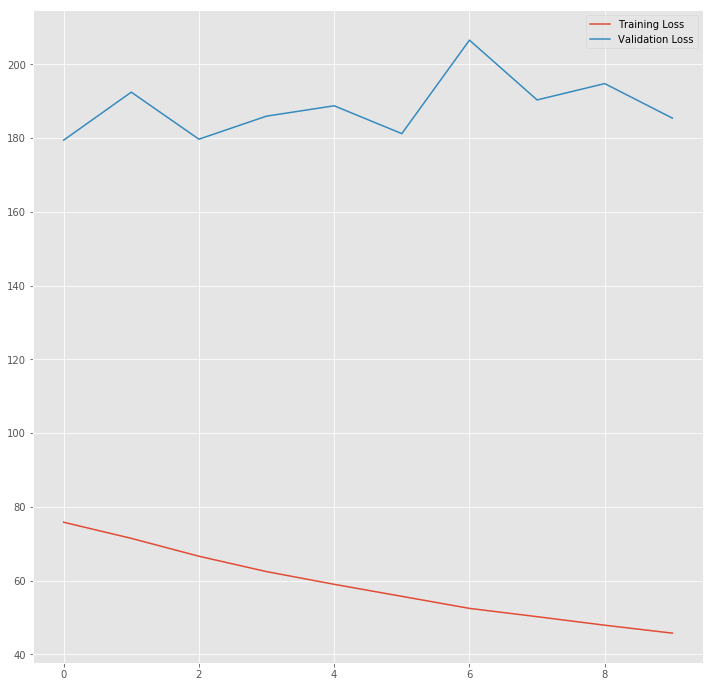

In [42]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"], label='Training Loss')
plt.plot(hist["val_loss"], label='Validation Loss')
plt.legend()
plt.show()

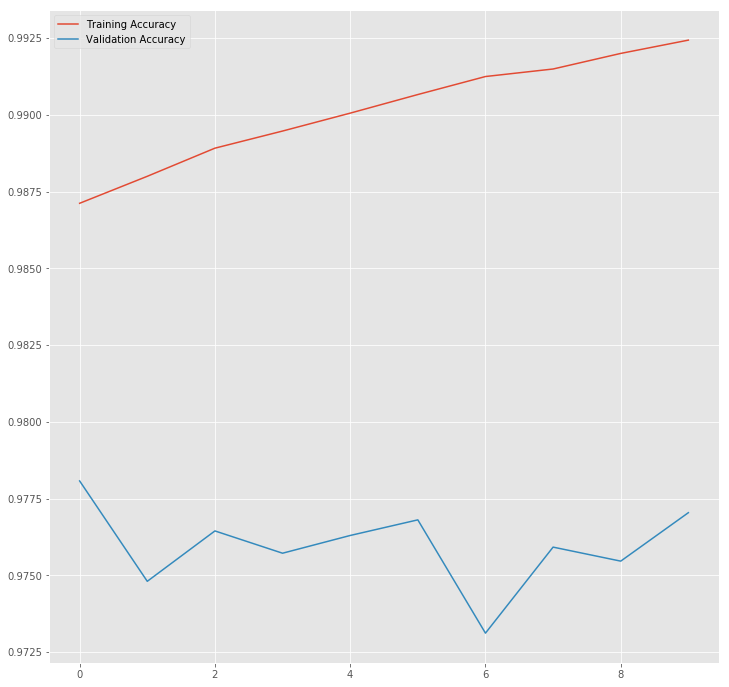

In [43]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"], label='Training Accuracy')
plt.plot(hist["val_acc"], label='Validation Accuracy')
plt.legend()
plt.show()

In [44]:
from sklearn.metrics import classification_report

predicted = model.predict([np.array(X_word_plain_te[:len(y_te)//32*32]), np.array(X_word_te[:len(y_te)//32*32]),
                    np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))[:len(y_te)//32*32]])
true = []
predicted_val = []
word = []
for i in range(len(predicted)):
    p_tmp = np.argmax(predicted[i], axis=-1)
    t_tmp = np.argmax(y_te[i], -1)
    word.append(X_word_te[i])
    predicted_val.append(p_tmp)
    true.append(t_tmp)

wd = [list(map(lambda x: idx2word[x], y)) for y in word]    
p = [list(map(lambda x: idx2tag[x], y)) for y in predicted_val]
t = [list(map(lambda x: idx2tag[x], y)) for y in true]

report = classification_report(list(itertools.chain.from_iterable(t)), 
                                    list(itertools.chain.from_iterable(p)))
# print "\n"
print(report)

              precision    recall  f1-score   support

B_GO:0000003       1.00      0.86      0.92         7
B_GO:0000075       0.54      1.00      0.70         7
B_GO:0000077       0.00      0.00      0.00         1
B_GO:0000086       0.00      0.00      0.00         1
B_GO:0000184       0.00      0.00      0.00         1
B_GO:0000187       0.00      0.00      0.00         2
B_GO:0000237       1.00      0.83      0.91         6
B_GO:0000238       1.00      0.50      0.67         2
B_GO:0000239       0.93      0.96      0.95        28
B_GO:0000240       1.00      0.93      0.96        14
B_GO:0000279       0.00      0.00      0.00         1
B_GO:0000322       0.00      0.00      0.00         1
B_GO:0000380       1.00      1.00      1.00        11
B_GO:0000502       0.00      0.00      0.00         1
B_GO:0000725       0.57      1.00      0.73         4
B_GO:0000785       0.86      0.80      0.83        15
B_GO:0000786       1.00      1.00      1.00         4
B_GO:0000792       0.87    

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [45]:
i = 300
pred = np.argmax(predicted[i], axis=-1)
print(pred)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, tr, pred in zip(X_word_te[i], np.argmax(y_te[i], -1), pred):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[tr], idx2tag[pred]))

[   0    0    0 1295    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
Word           ||True ||Pred
Chimeric       : O     O
males          : O     O
were           : O     O
mated          : B_GO:0007618 B_GO:0007618
with           : O     O
C57BL/6J       : O     O
females        : O     O
.              : O     O


In [46]:
import pandas as pd

df = pd.DataFrame(
{
    'Predicted' : list(itertools.chain.from_iterable(p)),
    'Ground Truth': list(itertools.chain.from_iterable(t)),
    'Word' : list(itertools.chain.from_iterable(wd)),
}
)


In [47]:
df = df[df['Word'] != 'O']

In [48]:
df1 = df[(df['Predicted'] != 'O') & (df['Ground Truth'] != 'O') | 
         (df['Predicted'] == 'O') & (df['Ground Truth'] != 'O') |
         (df['Predicted'] != 'O') & (df['Ground Truth'] == 'O')
        ]

report = classification_report(df1['Ground Truth'], 
                                    df1['Predicted'])
print("\n")
print(report)



              precision    recall  f1-score   support

B_GO:0000003       1.00      0.86      0.92         7
B_GO:0000075       0.54      1.00      0.70         7
B_GO:0000077       0.00      0.00      0.00         1
B_GO:0000086       0.00      0.00      0.00         1
B_GO:0000184       0.00      0.00      0.00         1
B_GO:0000187       0.00      0.00      0.00         2
B_GO:0000237       1.00      0.83      0.91         6
B_GO:0000238       1.00      0.50      0.67         2
B_GO:0000239       0.93      0.96      0.95        28
B_GO:0000240       1.00      0.93      0.96        14
B_GO:0000279       0.00      0.00      0.00         1
B_GO:0000322       0.00      0.00      0.00         1
B_GO:0000380       1.00      1.00      1.00        11
B_GO:0000502       0.00      0.00      0.00         1
B_GO:0000725       0.57      1.00      0.73         4
B_GO:0000785       0.86      0.80      0.83        15
B_GO:0000786       1.00      1.00      1.00         4
B_GO:0000792       0.87  

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [49]:
df.to_csv('../data/results/GO_merged_Exp.tsv', sep='\t')

In [50]:
!python2.7 ComputeSim.py ../data/results/GO_merged_Exp.tsv ../data/go/GO_AllSubsumers.tsv

('Mean semantic similarity: ', 0.762)
